# Test an organic molecules HOMO/LUMO and Transfer Integral With morphCT.

1. this notebooks seeks to display a simple workflow for using morphct functionalities to explore  the energetics of a given organic molecule. The energy level at the HOMO/LUMO is the foundation for everything morphct does. with that, veryfiying the accuracy of this calculation is a crucial first step when investigating a new molecule with morhct. 
2. In this notebook we will consider thiophene, which is the fundemental building block of P3HT (a benchmark electron donating compound. We will use to establish a worklow for comparing Morphct outputs with DFT or experimental results. However, this worklow should easily adapt to any organic compound whose energetic properties we might wish to investigate. 
3. Morphct models the charge mobility of a substance by considering where a charge may delocalize (on a chromophore) and modeling the rate at which that delocalized charge will hop to nieghboring molecules (or chromophores). Having done this for every chromophore in a morphology, morphct can run a simulation to model how well charges move around the environment.
4. Morphct models the rate at which a hop will take place between any two chromophores with semi classical Marcus Theory. To do so requires an accurate description of the driving force for electron transfer, and the orbital overlap of the two chromophores. Both of these can be estimated with the chromophores energy levels at the HOMO/LUMO (highest occupied molecular orbital/ lowest unoccupies molecular orbital). This estimation is a simplification for computational purposes, and it is, therefore, critical to verify that these assumptions match more rigorous theoretical techniques like DFT and experimental results (to whatever degree they are available). 
5. In short, we will take two thiophene rings to be two chromophores. Morphct will calculate the HOMO of both chomophores as well as the orbital overlap between them, as measured by the transfer integral (also estimated by the interaction of the two chromophores HOMOs). We will repeat this over thousands of angles and distances between the two rings.

In [2]:
import os
import mbuild as mb
import gsd.hoomd
import hoomd
import matplotlib.pyplot as plt
from mbuild import packing
import itertools as it
import numpy as np
from morphct import execute_qcc as eqcc
from morphct import mobility_kmc as kmc
from morphct import chromophores
from morphct import kmc_analyze
from morphct.chromophores import conversion_dict
from morphct.chromophores import amber_dict


/Users/jimmy/miniconda3/envs/morphct-ex/lib/python3.7/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


# Below we specify the smiles string for the molecule of interest (mbuild takes mol2 as well) and we use the mbuild fill_box to put two of these molecule in a box together with random orientations. We do this 100 times and save the outputs as gsds in the data/fillbox-gsds/ directory. Fill_box allows you to specifiy the density as well as the minimum distance apart that molecules should sit. In this case I have chosen .3nm, as this is what evans paper says is physically acceptable. 

In [2]:
#this is where you designate which molecule you want to investigate
path = "data/fillbox-gsds/"
thiophene = "C1=CSC=C1"
molecule = mb.load(thiophene, smiles=True)
transfer_integral_list_fillbox =[]

In [3]:
if not os.path.isdir("data/fillbox-gsds/"):
    os.makedirs("data/fillbox-gsds/")
thiophene = "C1=CSC=C1"
molecule = mb.load(thiophene, smiles=True)

seed = 100

for seed in range(seed):
    
    
    system = packing.fill_box(molecule,
                              n_compounds=2,
                              density = 500,
                              overlap = .3,
                              seed=seed,
                              fix_orientation=False)

    system.save(path + str(seed)+ ".gsd",overwrite=True)  

# HOMO/LUMO
With our gsds written out we can begin to use MorphCT to investigate the molecules energetics. First we will look at the HOMO/LUMO levels for thiophene, as calculated by MorphCT.

In [4]:
%%time
with gsd.hoomd.open(name=path + "1.gsd", mode='rb') as f:
    snap = f[0]
#isolate the indeces for one thiophene for input into morph
chromo_id = list(range(0,molecule.n_particles))
chromo_list=[]

chromo_list.append(chromophores.Chromophore(0, snap, chromo_id, "donor", amber_dict))

homolumo = eqcc.singles_homolumo(chromo_list)

print("the HOMO for your molecule is " + str(homolumo[0][1]) +" eV")
print("the LUMO is " + str(homolumo[0][2]) + " eV")


the HOMO for your molecule is -8.474013167764927 eV
the LUMO is 0.7754333507914352 eV
CPU times: user 17.8 ms, sys: 35.3 ms, total: 53 ms
Wall time: 1.62 s


MorphCT uses pySCF to do the quantum chemical calculations behind the above numbers. PYSCF uses a MINDO3 method to simplify the calculation. As you can see it only took seconds to calculate (go ahead and solve shrodingers in that time I dare you). The diagram below shows that the numbers are comparable to the more rigorous DFT methods used in the work cited below. 

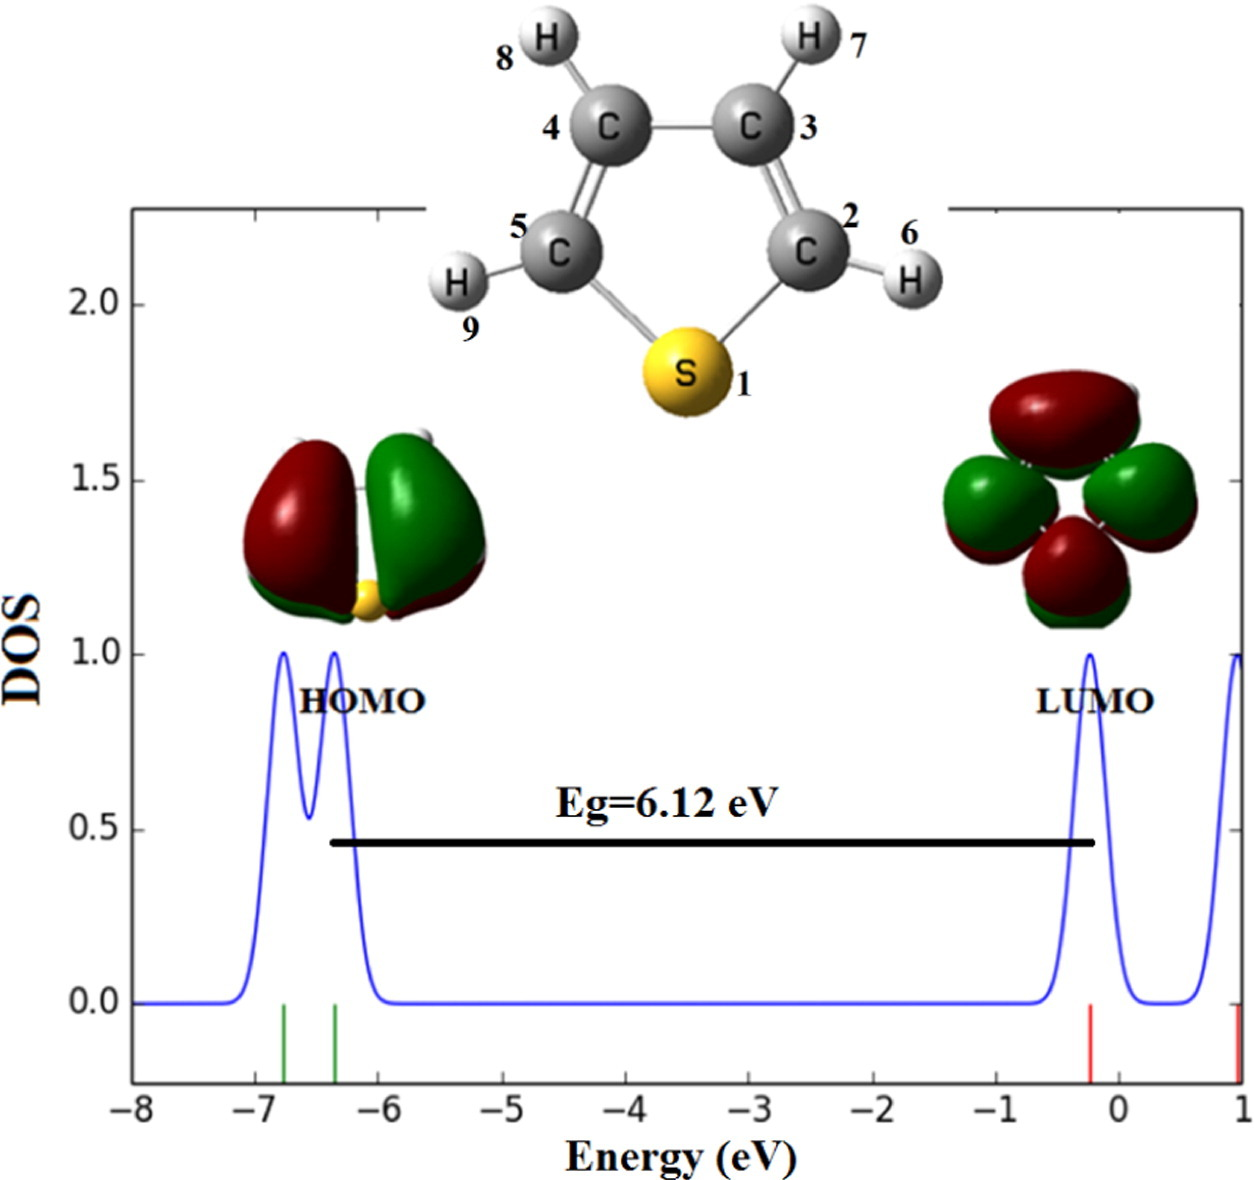

In [5]:
# https://doi.org/10.1016/j.molliq.2017.05.020
from IPython import display
display.Image("thiophene.jpg")

# TRANSFER INTEGRALS
Now we can get the transfer integral for our gsds. 

In [6]:
for file in os.listdir(path):
    
    with gsd.hoomd.open(name=path + file, mode='rb') as f:
        snap = f[0]
    # below just takes the indeces for particles in our gsds and
    #splites them into two chromophores
    chromo_ids = list(range(0,molecule.n_particles))
    chromo2_ids = np.add(chromo_ids, molecule.n_particles).tolist()
    ref_distance = 1
    
    snap.particles.position *= ref_distance
    snap.configuration.box[:3] *= ref_distance
    
    aaids=[]
    aaids.append(chromo_ids)
    aaids.append(chromo2_ids)
    chromo_list = []
    for i,aaid in enumerate(aaids):
        chromo_list.append(chromophores.Chromophore(i, snap, aaid, "donor", amber_dict))
        
    qcc_pairs = chromophores.set_neighbors_voronoi(chromo_list, snap, amber_dict, d_cut=100)
    
    dimer_data = eqcc.dimer_homolumo(qcc_pairs, chromo_list, "two-molecule-test.txt")
    
    data = eqcc.singles_homolumo(chromo_list, "singles.txt")
    
    eqcc.set_energyvalues(chromo_list, "singles.txt", "two-molecule-test.txt")
    chromo =chromo_list[1]
    transfer_integral_list_fillbox.append(chromo.neighbors_ti[0])

TypeError: '<' not supported between instances of 'str' and 'int'

 That gives a sample of randomly oreinted thiophenes. Printing the average vs the max
 to get an understanding of the shape of the data. in the supplimental info of this paper
 (https://www.mdpi.com/2073-4360/10/12/1358) it says TI variation within a factor of 2-3 
 is not expected to effect the mobility calculation and this is within those bounds

In [ ]:
print(np.mean(transfer_integral_list_fillbox))

In [ ]:
print(np.max(transfer_integral_list_fillbox))

# Specifying oreintations

1. If you want to do some analysis on specific oreintations of you molecule, the following code how this can be done. 
2. This analysis could take a very long time with a larger molecule. 

In [3]:
heat_tuple_list = []
transfer_integral_list = []
path = "data/analysis_gsds/"
if not os.path.isdir("data/analysis_gsds/"):
    os.makedirs("data/analysis_gsds")
smi = "C1=CSC=C1"
thiophene = mb.load(smi, smiles=True)
distances = np.linspace(0, 0.5, 10)
angles = np.linspace(0, np.pi/2, 10) # rotate around the sulfur axis (x-axis)
# or pitch although i cant understand why the sulfur isnt the cockpit
snap_list = []
#create a product space of distances and angles as delineated above. get two distances
# and two angles. assuming distance is a distance from the origin the if the distances from
# they are on top of each other and you can skip that one as in line 13
for d1, a1, d2, a2 in it.product(distances, angles, repeat=2):
    name = f"thiophene_d-{d1:.1f}-{d2:.1f}_a-{a1:.1f}-{a2:.1f}.gsd"
    if d1 == 0 and d2 == 0:
        continue
    #trying to say if the c - c distance is less than .3nm from evans paper 
    #skip they are too close for real life. and above .5 the TI is too weak
    #just from o
    if np.sqrt(d1**2+d2**2) < .3 or np.sqrt(d1**2+d2**2) > .5:
        continue
    system = mb.Compound()
    system.add(mb.clone(thiophene), "1")
    system.add(mb.clone(thiophene), "2")
    system["2"].rotate(a1, [0,0,1]) 
    system["2"].rotate(a2,[1,0,0])
    system["2"].translate([d1,0,d2])
    system.save("data/analysis_gsds/"+name, overwrite=True)
    gsd_file = path + name
    with gsd.hoomd.open(name=gsd_file, mode='rb') as f:
        snap = f[0]
        
    ref_distance = 1
    
    snap.particles.position *= ref_distance
    snap.configuration.box[:3] *= ref_distance
    chromo_ids = np.array([0,1,2,3,4,5,6,7,8,])
    chromo2_ids = np.array([9,10,11,12,13,14,15,16,17])
    aaids=[]
    aaids.append(chromo_ids)
    aaids.append(chromo2_ids)
    
    chromo_list = []
    for j,aaid in enumerate(aaids):
        chromo_list.append(chromophores.Chromophore(j, snap, aaid, "donor", amber_dict))
        
    qcc_pairs = chromophores.set_neighbors_voronoi(chromo_list, snap, amber_dict, d_cut=100)
    
    dimer_data = eqcc.dimer_homolumo(qcc_pairs, chromo_list, "two-molecule-test.txt")
    
    data = eqcc.singles_homolumo(chromo_list, "singles.txt")
    
    eqcc.set_energyvalues(chromo_list, "singles.txt", "two-molecule-test.txt")
    
    chromo =chromo_list[1]
    #dont know if ill need this or if the math is right
    #ss_dist= np.sqrt((d1*np.cos(a1))**2+(d1*np.sin(a1))**2+d2**2)
    cc_dist = np.sqrt(d1**2+d2**2)
    heat_tuple_list.append([cc_dist, a2 , chromo.neighbors_ti[0]])
    
    transfer_integral_list.append(chromo.neighbors_ti[0])

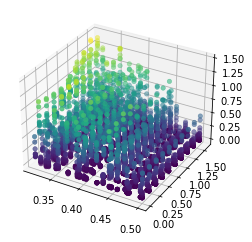

In [4]:
import seaborn as sns
x = [i[0] for i in heat_tuple_list]
y = [i[1] for i in heat_tuple_list]
z = [i[2] for i in heat_tuple_list]
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

In [13]:
len(transfer_integral_list)

4300

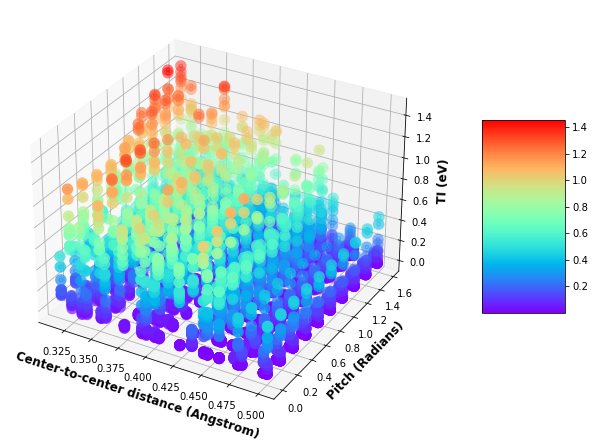

In [31]:
#import seaborn as sns
x = [i[0] for i in heat_tuple_list]
y = [i[1] for i in heat_tuple_list]
z = [i[2] for i in heat_tuple_list]
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.set_xlabel('Center-to-center distance (Angstrom)',fontdict=dict(weight='bold'),fontsize=12)
ax.set_ylabel('Pitch (Radians)',fontdict=dict(weight='bold'),fontsize=12)
ax.set_zlabel('TI (eV)',fontdict=dict(weight='bold'),fontsize=12)
#ax.set_title('Thiophene Transfer Integrals')
p = ax.scatter(x, y, z, c=z, cmap='rainbow', linewidth=7);
plt.colorbar(p, pad = .1, aspect = 2.3)



fig.show()

In [32]:
fig.savefig('transfer_integral_plot', bbox_inches = "tight", facecolor = "white")

In [24]:
pwd

'/Users/jimmy/repos/morphct-jimmy/examples'